# Natural language processing: spam detection

In [1]:
# Handle imports up-front
import spacy
import regex as re
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from nltk import download
from sklearn.svm import SVC
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.model_selection import GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

## 1. Data loading

### 1.1. Load the data

In [2]:
# Read csv file into dataframe
data_df=pd.read_csv('https://raw.githubusercontent.com/4GeeksAcademy/NLP-project-tutorial/main/url_spam.csv')

### 1.2. Inspect the data

In [3]:
# Your code here
print(data_df.head())

                                                 url  is_spam
0  https://briefingday.us8.list-manage.com/unsubs...     True
1                             https://www.hvper.com/     True
2                 https://briefingday.com/m/v4n3i4f3     True
3   https://briefingday.com/n/20200618/m#commentform    False
4                        https://briefingday.com/fan     True


In [4]:
print(data_df.info())
print(data_df['is_spam'].value_counts())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2999 entries, 0 to 2998
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   url      2999 non-null   object
 1   is_spam  2999 non-null   bool  
dtypes: bool(1), object(1)
memory usage: 26.5+ KB
None
is_spam
False    2303
True      696
Name: count, dtype: int64


### 1.3. Train-test split

In [5]:
# Your code here
from sklearn.model_selection import train_test_split

X = data_df['url']  # Features (URLs)
y = data_df['is_spam']  # Target labels (spam or non-spam)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

## 2. EDA

### 2.1. Text preprocessing

In [6]:
# Your code here - think about how you are cleaning the text. Look at some examples, are there words we should filter out?
def preprocess_url(url):
    url = url.lower()  # Convert to lowercase
    url = re.sub(r'www\.|https?:\/\/', '', url)  # Remove "www." and "http://"
    url = re.sub(r'[^a-z0-9]', ' ', url)  # Remove special characters
    return url

data_df['clean_url'] = data_df['url'].apply(preprocess_url)
print(data_df['clean_url'].head())  # See preprocessed URLs

0    briefingday us8 list manage com unsubscribe
1                                     hvper com 
2                     briefingday com m v4n3i4f3
3       briefingday com n 20200618 m commentform
4                            briefingday com fan
Name: clean_url, dtype: object


### 2.2. Lematization

In [7]:
# Your code here
nlp = spacy.load('en_core_web_sm')

def lemmatize_url(url):
    doc = nlp(url)
    return " ".join([token.lemma_ for token in doc])

data_df['lemmatized_url'] = data_df['clean_url'].apply(lemmatize_url)

### 2.3. Vectorization

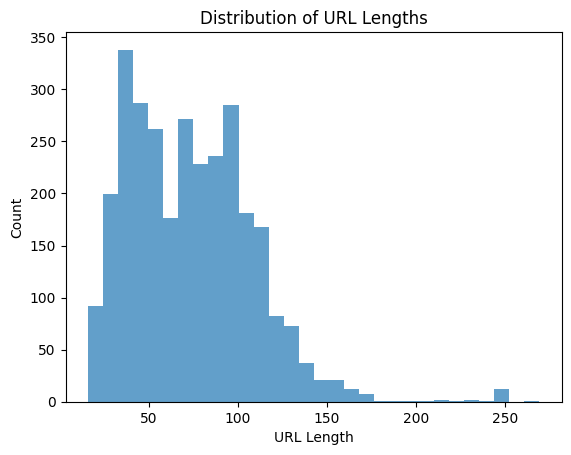

In [8]:
# Your code here. Take a look at the features. Do we need all of them? Could we reduce dimensionality or do feature selection?
data_df['url_length'] = data_df['url'].apply(len)
plt.hist(data_df['url_length'], bins=30, alpha=0.7)
plt.xlabel('URL Length')
plt.ylabel('Count')
plt.title('Distribution of URL Lengths')
plt.show()

In [9]:
vectorizer = TfidfVectorizer(max_features=5000)
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

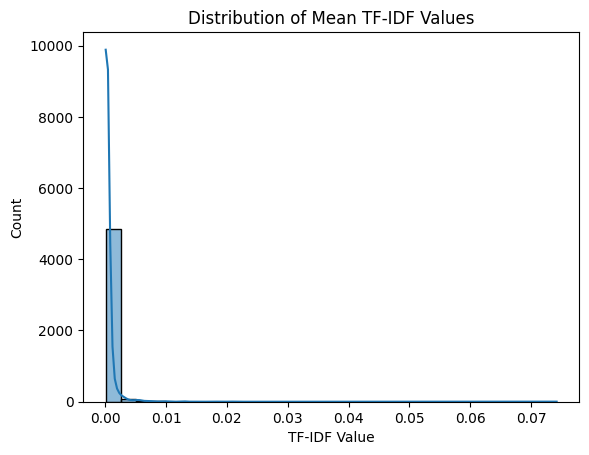

In [10]:
tfidf_values = X_train_tfidf.mean(axis=0).A1
sns.histplot(tfidf_values, bins=30, kde=True)
plt.xlabel("TF-IDF Value")
plt.ylabel("Count")
plt.title("Distribution of Mean TF-IDF Values")
plt.show()

## 3. SVM model

### 3.1. Baseline model performance

In [11]:
# Your code here
model = SVC(kernel='linear', random_state=42)
model.fit(X_train_tfidf, y_train)

y_pred = model.predict(X_test_tfidf)
print(f"Baseline Accuracy: {accuracy_score(y_test, y_pred):.4f}")

Baseline Accuracy: 0.9500


### 3.2. Hyperparameter optimization

In [12]:
# Do the optimization
param_grid = {'C': [0.1, 1, 10], 'kernel': ['linear', 'rbf']}
grid_search = GridSearchCV(SVC(), param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train_tfidf, y_train)

print("Best parameters:", grid_search.best_params_)

Best parameters: {'C': 10, 'kernel': 'rbf'}


In [13]:
# Use cross-validation to evaluate a new model trained with the best hyperparameter values from the optimization

## 4. Model evaluation

In [14]:
# Finally, try the model out on the test data. Be sure to process the test data the same way you did the training data!
X_test_processed = X_test.apply(preprocess_url).apply(lemmatize_url)
X_test_vectorized = vectorizer.transform(X_test_processed)

              precision    recall  f1-score   support

       False       0.95      0.98      0.96       461
        True       0.91      0.81      0.86       139

    accuracy                           0.94       600
   macro avg       0.93      0.89      0.91       600
weighted avg       0.94      0.94      0.94       600



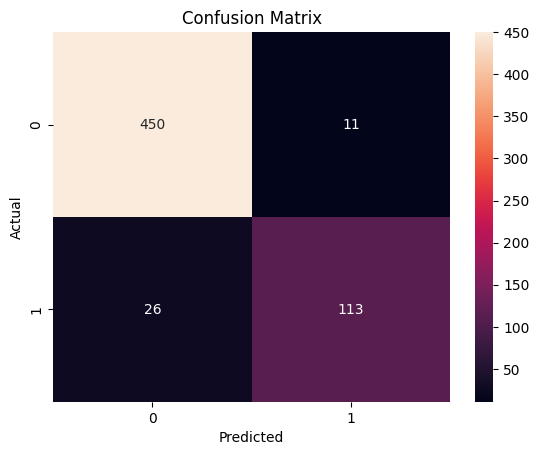

In [15]:
y_test_pred = model.predict(X_test_vectorized)
print(classification_report(y_test, y_test_pred))

conf_matrix = confusion_matrix(y_test, y_test_pred)
sns.heatmap(conf_matrix, annot=True, fmt="d")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

In [16]:
import joblib

joblib.dump(model, 'baseline_spam_detector.pkl')

print("Baseline model saved as 'baseline_spam_detector.pkl'")

Baseline model saved as 'baseline_spam_detector.pkl'
